# Setup
Our data is in a `results/<hw-type>/*.json` structure, we need to read this into a dataframe.

In [1]:
from huggingface_hub import login, whoami

login()

In [2]:
DATASET_PATH = f'{whoami()["name"]}/classifier-ie-optimization'

In [3]:
import pandas as pd
df = pd.read_parquet(f"hf://datasets/{DATASET_PATH}/data/train-00000-of-00001.parquet")

df[['hw_type', '1B_cost']].sort_values(by='1B_cost')

,hw_type,1B_cost
22,nvidia-l4,299.609978
40,nvidia-l4,300.262044
39,nvidia-l4,300.659867
23,nvidia-l4,301.088000
86,nvidia-l4,301.162511
...,...,...
67,nvidia-l4,1633.596140
66,nvidia-l4,1636.481821
71,nvidia-l4,1637.281330
89,nvidia-l4,1638.079394


In [4]:
df.columns

Index(['total_requests', 'test_duration_sec', 'successful_requests',
       'avg_latency_ms', 'p95_latency_ms', 'accuracy_percentage',
       'throughput_req_per_sec', 'hw_type', 'batch_size', 'engine', 'vendor',
       'vus', 'seconds_per_billion', 'cost_per_sec', '1B_cost'],
      dtype='object')

# Analysis

## Did we try enough VUs?
How do we know that we tried enough VUs? What if we tried a higher amount of VUs and throughput kept increasing? If thats the case then we would see a monotonicly increasing relationship between VUs and Throughput and we would need to run more tests. Lets check this out!

We can check by:
1. **Grouping data** by `hw_type` and `batch_size` to match how we generated the experiments
1. **Sorting the data** by `vus` within each group to ensure we get the data in the correct order for our check
1. **Check for monotonic increase** in `throughput_req_per_sec` flag the groups that always increase throughput as VUs increase


Note: do a sanity check with the following code to make sure that this does indeed detect if it does in-fact detect the series you expect.
```python
df_filtered = df[df['vus'] <= 256]`
grouped = df_filtered.groupby(['hw_type', 'batch_size'])
```


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Grouping by 'hw_type' and 'batch_size'
grouped = df.groupby(['hw_type', 'batch_size'])

# Identifying monotonically increasing series for throughput_req_per_sec as vus increases
monotonic_series = {}
for (hw_type, batch_size), group in grouped:
    group_sorted = group.sort_values('vus')  # Ensure sorted order by vus
    if group_sorted['throughput_req_per_sec'].is_monotonic_increasing:
        monotonic_series[(hw_type, batch_size)] = group_sorted[['vus', 'throughput_req_per_sec']]

# Plotting the identified monotonically increasing series
for (hw_type, batch_size), data in monotonic_series.items():
    plt.figure(figsize=(8, 5))
    plt.plot(data['vus'], data['throughput_req_per_sec'], marker='o', linestyle='-')
    plt.xlabel('Virtual Users (VUs)')
    plt.ylabel('Throughput (Requests per Sec)')
    plt.title(f'Throughput Trend for HW: {hw_type}, Batch: {batch_size}')
    plt.grid(True)
    plt.show()

# Display the results in a DataFrame
monotonic_df = pd.DataFrame(
    [(hw, batch) for (hw, batch) in monotonic_series.keys()],
    columns=['hw_type', 'batch_size']
)

print(monotonic_df)


Empty DataFrame
Columns: [hw_type, batch_size]
Index: []


## Are we accurate enough?
We shouldn't expect to see significant changes in accuracy. We should see a pretty tight distribution, but there might be some deviation since for lower VUs we wont have as many samples of our `10_000` that we saw with higher VUs.

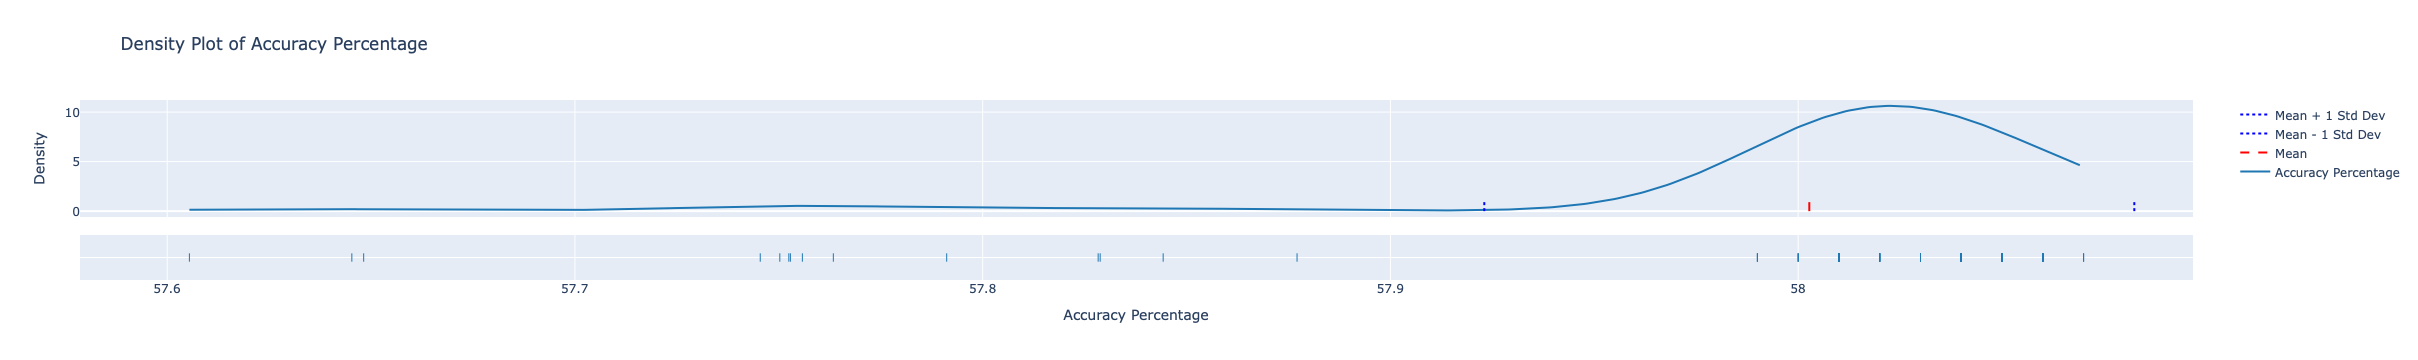

In [12]:
import plotly.figure_factory as ff
import plotly.graph_objects as go

mean_accuracy = df["accuracy_percentage"].mean()
std_dev_accuracy = df["accuracy_percentage"].std()

# Create a distribution plot (outline instead of bins)
fig = ff.create_distplot([df['accuracy_percentage']], ['Accuracy Percentage'], show_hist=False, show_rug=True)

# Add mean and standard deviation lines
fig.add_trace(go.Scatter(x=[mean_accuracy, mean_accuracy], y=[0, 1],
                         mode="lines", name="Mean", line=dict(color="red", dash="dash")))

fig.add_trace(go.Scatter(x=[mean_accuracy - std_dev_accuracy, mean_accuracy - std_dev_accuracy],
                         y=[0, 1],
                         mode="lines", name="Mean - 1 Std Dev", line=dict(color="blue", dash="dot")))

fig.add_trace(go.Scatter(x=[mean_accuracy + std_dev_accuracy, mean_accuracy + std_dev_accuracy],
                         y=[0, 1],
                         mode="lines", name="Mean + 1 Std Dev", line=dict(color="blue", dash="dot")))

# Update layout
fig.update_layout(title="Density Plot of Accuracy Percentage",
                  xaxis_title="Accuracy Percentage",
                  yaxis_title="Density",
                  showlegend=True)

# Show figure
fig.show()

In [13]:
# Display statistics
stats_df = pd.DataFrame({'Statistic': ['Mean', 'Standard Deviation'],
                         'Value': [mean_accuracy, std_dev_accuracy]})
stats_df

,Statistic,Value
0,Mean,58.00273
1,Standard Deviation,0.07971


Here we can see some deviation with a large z-score, but overall its not that big of an absolute devation. These also occur when we have relatively low `total_requests` which makes sense. 

We should worry more if we see major `absolute_deviation` with higher `total_requests`.

In [14]:
from scipy.stats import zscore

# Calculate absolute deviation from the mean
df['absolute_deviation'] = abs(df['accuracy_percentage'] - mean_accuracy)

# Calculate z-score
df['z_score'] = zscore(df['accuracy_percentage'])

# Get the top 5 outliers with the highest absolute deviation
top_outliers = df.nlargest(5, 'absolute_deviation')[['vus', 'batch_size', 'total_requests', 'accuracy_percentage', 'absolute_deviation', 'z_score']]
top_outliers['accuracy_percentage'] = top_outliers['accuracy_percentage'].round(2)
top_outliers['absolute_deviation'] = top_outliers['absolute_deviation'].round(2)
top_outliers['z_score'] = top_outliers['z_score'].round(2)

top_outliers

,vus,batch_size,total_requests,accuracy_percentage,absolute_deviation,z_score
167,32,1024,7350,57.61,0.40,-5.00
157,32,64,7279,57.65,0.36,-4.50
106,32,256,7322,57.65,0.35,-4.46
71,32,256,8179,57.75,0.26,-3.24
56,32,1024,8232,57.75,0.25,-3.18


## Cost vs Latency

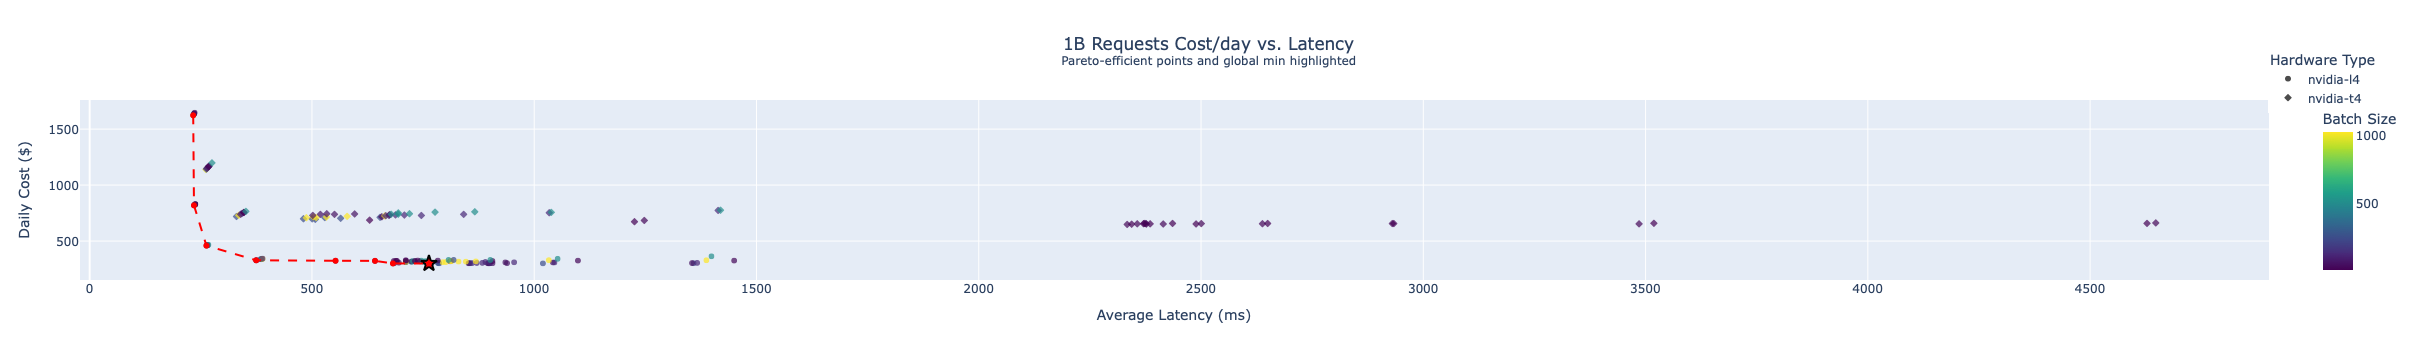

In [18]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Get the 100 lowest-cost points
bottom_100 = df.nsmallest(500, "1B_cost").copy()
bottom_100["1B_cost"] = bottom_100["1B_cost"].round(2)
bottom_100["throughput_req_per_sec"] = bottom_100["throughput_req_per_sec"].round(2)
bottom_100["avg_latency_ms"] = bottom_100["avg_latency_ms"].round(3)

# Find the global minimum cost point *only within* the bottom 100 points
global_min = bottom_100.nsmallest(1, "1B_cost")

# Function to find Pareto-efficient points (minimizing cost and latency)
def pareto_efficient(df, x_col, y_col):
    sorted_df = df.sort_values(by=[x_col, y_col])  # Sort by latency, then cost
    pareto_points = []
    min_cost = np.inf  # Start with a very high cost
    
    for _, row in sorted_df.iterrows():
        if row[y_col] < min_cost:  # If this cost is the lowest seen so far
            pareto_points.append(row)
            min_cost = row[y_col]
    
    return pd.DataFrame(pareto_points)

# Compute Pareto front
pareto_front = pareto_efficient(bottom_100, "avg_latency_ms", "1B_cost")

# Base scatter plot (showing 100 lowest-cost points)
fig = px.scatter(
    bottom_100, 
    x="avg_latency_ms", 
    y="1B_cost", 
    symbol="hw_type", 
    color="batch_size",  
    color_continuous_scale="viridis",  
    opacity=0.7, 
    title="1B Requests Cost/day vs. Latency<br><sup>Pareto-efficient points and global min highlighted</sup>",
    labels={
        "avg_latency_ms": "Average Latency (ms)",
        "1B_cost": "Daily Cost ($)",
        "hw_type": "Hardware Type",
        "batch_size": "Batch Size",
    },
    hover_data=["vus", "batch_size", "throughput_req_per_sec"]
)

# Add global minimum cost point (red star)
fig.add_trace(
    go.Scatter(
        x=global_min["avg_latency_ms"],
        y=global_min["1B_cost"],
        mode="markers",
        marker=dict(size=12, color="red", symbol="star", line=dict(width=2, color="black")),
        name="Global Min Cost",
        hovertemplate="Latency: %{x} ms<br>Cost: $%{y}<br>Batch Size: %{text}<br>VUs: %{customdata[0]}<br>Throughput: %{customdata[1]} req/sec",
        text=global_min["batch_size"],
        customdata=global_min[["vus", "throughput_req_per_sec"]].values,
        showlegend=False
    )
)

# Add Pareto curve with detailed hover info
fig.add_trace(
    go.Scatter(
        x=pareto_front["avg_latency_ms"],
        y=pareto_front["1B_cost"],
        mode="lines+markers",
        line=dict(color="red", width=2, dash="dash"),
        marker=dict(size=6, color="red"),
        name="Pareto Front",
        hovertemplate="Latency: %{x} ms<br>Cost: $%{y}<br>Batch Size: %{text}<br>VUs: %{customdata[0]}<br>Throughput: %{customdata[1]} req/sec",
        text=pareto_front["batch_size"],
        customdata=pareto_front[["vus", "throughput_req_per_sec"]].values,
        showlegend=False
    )
)

# Adjust layout (Center title)
fig.update_layout(
    title_x=0.5,  # Centers title
    legend=dict(
        x=1,  
        y=1.3,  
        title="Hardware Type"
    )
)

fig.show()


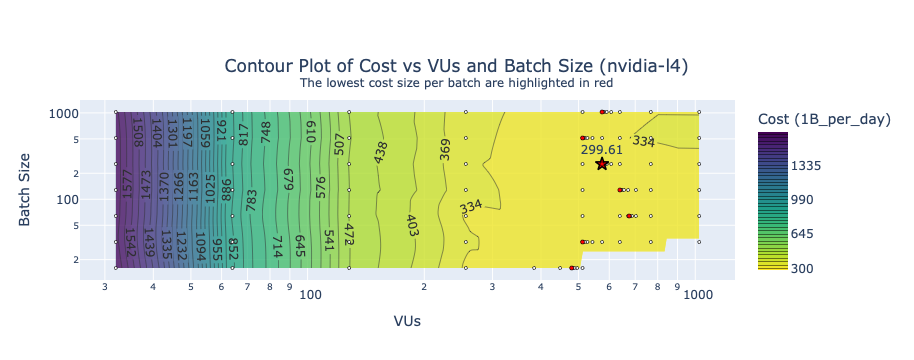

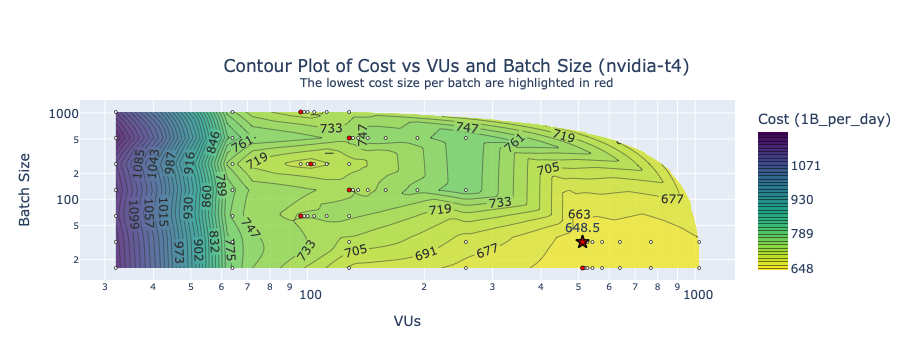

In [25]:
import plotly.graph_objects as go
import scipy.interpolate
import numpy as np
import pandas as pd
import base64
import json

# Load your DataFrame (ensure it contains 'vus', 'batch_size', '1B_cost', and 'hw_type')
contour_figs = {}
for hw in df["hw_type"].unique():
    df_hw = df[(df["hw_type"] == hw) & (df["vus"] > 20)].copy()

    # Define percentile bins for cost
    percentiles = np.linspace(0, 100, 40)  # Define bins using percentiles
    cost_bins = np.percentile(df_hw["1B_cost"], percentiles)  # Compute cost bins

    # Create grid for interpolation (Now X = VUs, Y = batch_size)
    grid_x_real, grid_y_real = np.meshgrid(
        np.linspace(df_hw["vus"].min(), df_hw["vus"].max(), 100),  # X-axis is now VUs
        np.linspace(df_hw["batch_size"].min(), df_hw["batch_size"].max(), 100)  # Y-axis is now batch_size
    )

    # Interpolate cost data (Now X = VUs, Y = batch_size)
    grid_z_real = scipy.interpolate.griddata(
        (df_hw["vus"], df_hw["batch_size"]),  # Order remains the same
        df_hw["1B_cost"],
        (grid_x_real, grid_y_real),  # Adjusted grid order
        method='linear'  # Linear interpolation for smoother transitions
    )

    # Identify the 5 lowest cost points
    lowest_cost_points = df_hw.nsmallest(1, "1B_cost")

    # Identify the minimum cost point for each batch size
    min_per_batch = df_hw.loc[df_hw.groupby("batch_size")["1B_cost"].idxmin()]

    # Create Plotly figure
    fig_hw = go.Figure()

    # Contour plot with percentile-based cost bins
    fig_hw.add_trace(
        go.Contour(
            z=grid_z_real,
            x=np.linspace(df_hw["vus"].min(), df_hw["vus"].max(), 100),  # X-axis is now VUs
            y=np.linspace(df_hw["batch_size"].min(), df_hw["batch_size"].max(), 100),  # Y-axis is now batch_size
            colorscale="viridis_r",
            contours=dict(
                start=cost_bins[0],
                end=cost_bins[-1],
                size=np.diff(cost_bins).mean(),  # Uses percentile bins
                showlabels=True
            ),
            colorbar=dict(title="Cost (1B_per_day)"),
            hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{z}",
            opacity=0.8  # Reduce opacity to make scatter points stand out
        )
    )

    # Scatter plot of actual data points
    fig_hw.add_trace(
        go.Scatter(
            x=df_hw["vus"],  # X-axis is now VUs
            y=df_hw["batch_size"],  # Y-axis is now batch_size
            mode="markers",
            marker=dict(size=3, color="white", line=dict(width=0.5, color="black")),  
            name="Real Data Points",
            hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
            text=df_hw["1B_cost"].round(2),
            showlegend=False
        )
    )

    # Scatter plot for lowest global cost points (Red Stars)
    fig_hw.add_trace(
        go.Scatter(
            x=lowest_cost_points["vus"],
            y=lowest_cost_points["batch_size"],
            mode="markers+text",
            marker=dict(size=10, color="red", symbol="star", line=dict(width=1.5, color="black")),
            name="Lowest 5 Cost Points",
            hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
            text=lowest_cost_points["1B_cost"].round(2),
            textposition="top center",
            showlegend=False
        )
    )

    # Scatter plot for minimum cost per batch size (Small Red Dots)
    fig_hw.add_trace(
        go.Scatter(
            x=min_per_batch["vus"],
            y=min_per_batch["batch_size"],
            mode="markers",
            marker=dict(size=4, color="red", line=dict(width=0.5, color="black")),
            name="Min Cost per Batch Size",
            hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
            text=min_per_batch["1B_cost"].round(2),
            showlegend=False
        )
    )

    fig_hw.update_layout(
        title=f"Cost vs VUs and Batch Size ({hw})",
        xaxis_title="VUs",
        yaxis_title="Batch Size",
        xaxis_type="log",
        yaxis_type="log"
    )

    fig_hw.update_layout(
    title={
        "text": f"Contour Plot of Cost vs VUs and Batch Size ({hw})<br><sup>The lowest cost size per batch are highlighted in red</sup>",
        "x": 0.5,  # Center align
        "y": 0.8,  # Adjust vertical position
    }
    )

    fig_hw.show()
    contour_figs[hw] = fig_hw.to_json()

encoded_data = base64.b64encode(json.dumps(contour_figs).encode()).decode()

In [30]:
from IPython.display import display, HTML

code = f'''
<html>
	<head>
		<script type="module" crossorigin src="https://cdn.jsdelivr.net/npm/@gradio/lite/dist/lite.js"></script>
        <script src="https://cdn.plot.ly/plotly-2.1.0.min.js"></script>
	</head>
	<body>
		<gradio-lite>
        <gradio-requirements>
        plotly
        </gradio-requirements>
        import json
        import gradio as gr
        import base64
        import plotly.io as pio

        encoded_data = "{encoded_data}"
        decoded_data = json.loads(base64.b64decode(encoded_data).decode())

        def get_plot(hw_type):
            return pio.from_json(decoded_data[hw_type])

        with gr.Blocks() as demo:
            gr.Markdown("# Cost Contour Analysis")
            hw_dropdown = gr.Dropdown(choices=list(decoded_data.keys()), label="Select Hardware Type")
            plot_output = gr.Plot(label="Contour Plot")

            hw_dropdown.change(get_plot, hw_dropdown, plot_output)

        demo.launch()
        </gradio-lite>
	</body>
</html>
'''

display(HTML(code))
